# Clustering - Introduction
This notebook is a third part of [eargasm-spotify](https://github.com/adamsiemaszkiewicz/eargasm-music) repository meant to cluster the playlist and track information from the [eargasm music channel](https://open.spotify.com/user/eargasmusic?si=HtTLbkG6QoqkdKU3uTRjAQ) at Spotify.

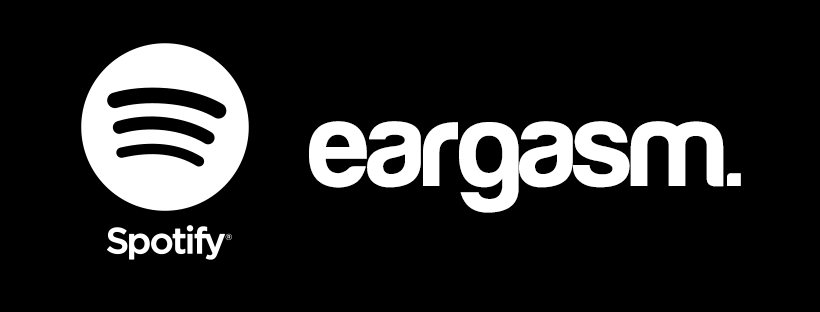

# Set up environment

## Google Drive mount

In [1]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [2]:
%cd /content/gdrive/My Drive/Colab Notebooks/eargasm-music/

/content/gdrive/My Drive/Colab Notebooks/eargasm-music


In [3]:
!ls

'=4.7.1'	      basic_info.csv		      files
 all_playlists.csv    eargasm_Classification.ipynb    final_df.csv
 audio_analysis.csv   eargasm_DataExploration.ipynb   genres.csv
 audio_features.csv   eargasm_DataRetrieval.ipynb     README.md


In [11]:
!pip install category_encoders

     |████████████████████████████████| 81kB 3.4MB/s 


## Import libraries and functions
Let's import all the libraries and function we're gonna use throughout the notebook.

### Notebook
- `tqdm.notebook` `tqdm` - Progress bars

In [4]:
from tqdm.notebook import tqdm

### Data science
- `pandas` - data manipulation & analysis
- `pd.options.mode.chained_assignment` - switch off warning for chained_assignment
- `numpy` - linear algebra

In [5]:
import pandas as pd
import numpy as np

### Visualization
- `matplotlib.pyplot` - basic visualizations
- `plotly` - advanced visualizations
- `plotly.express` - fast vizualizations
- `plotly.graph_objects` - more control over plotly figures

In [6]:
import matplotlib.pyplot as plt
import plotly
import plotly.express as px
import plotly.io as pio
import plotly.graph_objects as go

## Machine learning

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
import category_encoders as ce


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



# Load data
Let's load the data fetched from the [Eargasm Music](https://open.spotify.com/user/eargasmusic?si=cz4VzEi1RgaUup_g8-UnEg) Spotify channel using `eargasm_retrieve-data.ipynb`. The data set consists of the tracks with their features as well as a playlist name label.

In [8]:
final_df = pd.read_csv('files/final_df.csv', index_col=0)
final_df.head()

,track_id,track_artist,track_artistid,track_name,track_duration,track_popularity,track_releasedate,track_preview,track_image,track_url,track_playlist,track_genre,acousticness,danceability,energy,instrumentalness,liveness,speechiness,valence,key,key_confidence,mode,mode_confidence,number_of_sections,tempo,tempo_confidence,time_signature,time_signature_confidence
0,1ua6hBq18qZLyprXjMcpyf,Virgil Howe,6d3Hil7Y1xq0oEhtaDxEUg,Someday,251266,43,2009-10-19,https://p.scdn.co/mp3-preview/a2bdcba6acda937f...,https://i.scdn.co/image/ab67616d0000b27356dc5e...,https://open.spotify.com/track/1ua6hBq18qZLypr...,eargasm | breathe easy,NaN,0.370,0.483,0.462,0.210000,0.0875,0.0290,0.351,9.0,0.292,0.0,0.398,12.0,86.502,0.160,4.0,1.000
1,42VpxSdGQgnV1UJkWeGYkA,Cass McCombs,2iUVQjheBnvOt8vaBrxXJz,Switch,254233,52,2016-08-26,https://p.scdn.co/mp3-preview/d0feea85b84ce9f5...,https://i.scdn.co/image/ab67616d0000b27396782c...,https://open.spotify.com/track/42VpxSdGQgnV1UJ...,eargasm | breathe easy,alternative country,0.362,0.682,0.538,0.000123,0.3240,0.0283,0.713,7.0,0.743,0.0,0.453,12.0,98.003,0.583,4.0,1.000
2,1g8A166soQjwl1ihqBWKGW,The Slow Revolt,7cfCmW2AFiMNdpJdY0vJsr,Lean,207699,0,2016-09-09,NaN,https://i.scdn.co/image/ab67616d0000b273ce48d6...,https://open.spotify.com/track/1g8A166soQjwl1i...,eargasm | breathe easy,vapor pop,0.195,0.536,0.753,0.801000,0.1200,0.0309,0.676,1.0,0.655,1.0,0.368,12.0,85.036,0.325,4.0,0.979
3,6cAVWcj8TQ5yR2T6BZjnOg,Dirty Nice,4MGA6AM4iZ2HYc6b77og9g,Zero Summer,212640,0,2017-06-09,NaN,https://i.scdn.co/image/ab67616d0000b2733a028c...,https://open.spotify.com/track/6cAVWcj8TQ5yR2T...,eargasm | breathe easy,NaN,0.742,0.663,0.509,0.000006,0.1120,0.0889,0.303,11.0,0.547,1.0,0.560,12.0,125.088,0.476,4.0,0.845
4,3YA509E9ki7a3Ic9cf25Vt,Alex Ebert,1me05HW5s7TShHra5nN7uE,Broken Record,274800,47,2017-05-05,https://p.scdn.co/mp3-preview/96c62ba3b9d730d3...,https://i.scdn.co/image/ab67616d0000b2738a6904...,https://open.spotify.com/track/3YA509E9ki7a3Ic...,eargasm | breathe easy,alternative americana,0.240,0.464,0.570,0.001210,0.1380,0.0400,0.548,0.0,0.905,1.0,0.753,12.0,170.556,0.183,4.0,0.799


# Feature engineering

In [17]:
df_copy = final_df.copy()

encoder = ce.BinaryEncoder(cols=['track_artist'])
df_binary = encoder.fit_transform(df_copy)

df_binary

/usr/local/lib/python3.6/dist-packages/category_encoders/utils.py:21: FutureWarning:

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead



,track_id,track_artist_0,track_artist_1,track_artist_2,track_artist_3,track_artist_4,track_artist_5,track_artist_6,track_artist_7,track_artist_8,track_artist_9,track_artist_10,track_artist_11,track_artistid,track_name,track_duration,track_popularity,track_releasedate,track_preview,track_image,track_url,track_playlist,track_genre,acousticness,danceability,energy,instrumentalness,liveness,speechiness,valence,key,key_confidence,mode,mode_confidence,number_of_sections,tempo,tempo_confidence,time_signature,time_signature_confidence
0,1ua6hBq18qZLyprXjMcpyf,0,0,0,0,0,0,0,0,0,0,0,1,6d3Hil7Y1xq0oEhtaDxEUg,Someday,251266,43,2009-10-19,https://p.scdn.co/mp3-preview/a2bdcba6acda937f...,https://i.scdn.co/image/ab67616d0000b27356dc5e...,https://open.spotify.com/track/1ua6hBq18qZLypr...,eargasm | breathe easy,NaN,0.370,0.483,0.462,0.210000,0.0875,0.0290,0.3510,9.0,0.292,0.0,0.398,12.0,86.502,0.160,4.0,1.000
1,42VpxSdGQgnV1UJkWeGYkA,0,0,0,0,0,0,0,0,0,0,1,0,2iUVQjheBnvOt8vaBrxXJz,Switch,254233,52,2016-08-26,https://p.scdn.co/mp3-preview/d0feea85b84ce9f5...,https://i.scdn.co/image/ab67616d0000b27396782c...,https://open.spotify.com/track/42VpxSdGQgnV1UJ...,eargasm | breathe easy,alternative country,0.362,0.682,0.538,0.000123,0.3240,0.0283,0.7130,7.0,0.743,0.0,0.453,12.0,98.003,0.583,4.0,1.000
2,1g8A166soQjwl1ihqBWKGW,0,0,0,0,0,0,0,0,0,0,1,1,7cfCmW2AFiMNdpJdY0vJsr,Lean,207699,0,2016-09-09,NaN,https://i.scdn.co/image/ab67616d0000b273ce48d6...,https://open.spotify.com/track/1g8A166soQjwl1i...,eargasm | breathe easy,vapor pop,0.195,0.536,0.753,0.801000,0.1200,0.0309,0.6760,1.0,0.655,1.0,0.368,12.0,85.036,0.325,4.0,0.979
3,6cAVWcj8TQ5yR2T6BZjnOg,0,0,0,0,0,0,0,0,0,1,0,0,4MGA6AM4iZ2HYc6b77og9g,Zero Summer,212640,0,2017-06-09,NaN,https://i.scdn.co/image/ab67616d0000b2733a028c...,https://open.spotify.com/track/6cAVWcj8TQ5yR2T...,eargasm | breathe easy,NaN,0.742,0.663,0.509,0.000006,0.1120,0.0889,0.3030,11.0,0.547,1.0,0.560,12.0,125.088,0.476,4.0,0.845
4,3YA509E9ki7a3Ic9cf25Vt,0,0,0,0,0,0,0,0,0,1,0,1,1me05HW5s7TShHra5nN7uE,Broken Record,274800,47,2017-05-05,https://p.scdn.co/mp3-preview/96c62ba3b9d730d3...,https://i.scdn.co/image/ab67616d0000b2738a6904...,https://open.spotify.com/track/3YA509E9ki7a3Ic...,eargasm | breathe easy,alternative americana,0.240,0.464,0.570,0.001210,0.1380,0.0400,0.5480,0.0,0.905,1.0,0.753,12.0,170.556,0.183,4.0,0.799
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3616,7KcTpjtgreexlmorl41QeT,0,1,1,0,0,0,0,1,1,0,0,1,7GsvnIE0bUBu6WZXO3ryJe,Sequoia,228000,21,2018-02-27,https://p.scdn.co/mp3-preview/4bfab56eb42cb468...,https://i.scdn.co/image/ab67616d0000b273a96460...,https://open.spotify.com/track/7KcTpjtgreexlmo...,eargasm | weightless,lo-fi beats,0.982,0.419,0.270,0.955000,0.0789,0.0282,0.0738,1.0,0.531,0.0,0.552,12.0,72.444,0.209,4.0,0.956
3617,7sljgxqi3fK5vmV7t2St1l,0,1,1,0,0,0,0,1,1,0,1,0,4oCcCzMjKNCjQTzxtVlOJT,Black Willow - Single Version,239458,41,2017-11-15,https://p.scdn.co/mp3-preview/8a3f928d152318da...,https://i.scdn.co/image/ab67616d0000b27336ed83...,https://open.spotify.com/track/7sljgxqi3fK5vmV...,eargasm | weightless,chamber psych,0.852,0.672,0.339,0.013900,0.1140,0.0247,0.3040,3.0,0.300,0.0,0.473,12.0,139.988,0.319,4.0,0.946
3618,3pMMsJOMjgk2k9dMNTrrDu,0,1,1,0,0,0,0,1,1,0,1,1,0uUIxKwkvqgcHmFRnvEn8G,Reminiscences,344969,21,2018-03-02,https://p.scdn.co/mp3-preview/aa2d6b892f6f425f...,https://i.scdn.co/image/ab67616d0000b273164412...,https://open.spotify.com/track/3pMMsJOMjgk2k9d...,eargasm | weightless,NaN,0.843,0.712,0.199,0.575000,0.1060,0.0369,0.0930,8.0,0.774,0.0,0.426,12.0,116.038,0.682,4.0,0.431
3619,01CBH5z1p01xSEsiSSykSx,0,1,1,0,0,0,0,1,1,1,0,0,1puNKd1JxQc5ULmcei2mb3,London Lullaby,297752,19,2018-01-26,https://p.scdn.co/mp3-preview/a0818019d3190145...,https://i.scdn.co/image/ab67616d0000b2734b8f9d...,https://open.spotify.com/track/01CBH5z1p01xSEs...,eargasm | weightless,NaN,0.798,0.613,0.364,0.000

# Set split

In [9]:
features_to_keep = ['track_artist',
                    'track_duration',
                    'track_popularity',
                    'track_releasedate',
                    'track_genre',
                    'acousticness',
                    'danceability',
                    'energy',
                    'instrumentalness',
                    'liveness',
                    'speechiness',
                    'valence',
                    'key',
                    'key_confidence',
                    'mode',
                    'mode_confidence',
                    'number_of_sections',
                    'tempo',
                    'tempo_confidence',
                    'time_signature',
                    'time_signature_confidence'
                    ]
X = final_df[features_to_keep]
y = final_df['track_playlist']
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    random_state=0)

## track_artist

In [10]:
X['track_artist'].astype('category', inplace=True)
X

TypeError: ignored

In [ ]:
print('{} unique values out of {} records.'.format( str(len(X['track_artist'].unique())), len(X['track_artist'])))

In [ ]:
knn = KNeighborsClassifier(n_neighbors = 5)

In [ ]:
knn.fit(X_train, y_train)

# References
- https://contrib.scikit-learn.org/category_encoders/
- https://www.datacamp.com/community/tutorials/categorical-data